# Transfer Kernel Model Simulation

In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_plotly
%run -m ipy_seaborn
%matplotlib inline
import tensorflow as tf
import edward as ed
from edward.models import Normal, Bernoulli
from mgds.data_modeling.nbfn import mkl as mkl
from mgds.data_modeling.nbfn import model_mkl04 as mklmodel
from ml.edward import models as ed_models
from ml.tensorflow.utilities import tf_eval
SEED = 1

2017-04-15 12:11:30,471:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


The purpose of this simulation is to test the assumptions of a certain model that, at the moment, I'm calling a "Transfer Kernel Model".  This idea might have already been applied elsewhere but I haven't seen it so I'll just call it that for now.

The need for this arose from the following situation:

1. Imagine that I have 

In [2]:
def run(T):
    return tf_eval(T)

In [86]:
P = 1000
Nr = 500
Nd = 100
Tr = 15
Td = 8

# P = 100
# Nr = 200
# Nd = 20
# Tr = 10
# Td = 3


def get_rppa_covariates():
    X = Normal(mu=1.*np.zeros([Nr, P]), sigma=1.*np.ones([Nr, P]))
    return run(X)

def get_drug_covariates():
    X = Normal(mu=1.*np.zeros([Nd, P]), sigma=1.*np.ones([Nd, P]))
    return run(X)

def get_rppa_weights():
    p = 50
    assert P >= p
    p = float(p)/P
    selector = tf.cast(Bernoulli(p=p*np.ones([P, Tr])), dtype=tf.float32)
    weight = Normal(mu=tf.zeros([P, Tr]), sigma=tf.ones([P, Tr]))
    return run(weight * selector) # P x Tr

def get_drug_weights():
    p = 3
    assert Tr >= p
    p = float(p)/Tr
    selector = tf.cast(Bernoulli(p=p*np.ones([Tr, Td])), dtype=tf.float32)
    weight = Normal(mu=tf.zeros([Tr, Td]), sigma=tf.ones([Tr, Td]))
    return run(weight * selector) # Tr x Td


def get_drug_response(Xd, Wd, Wr):
    # Xd = Nd x P
    # Wd = Tr x Td
    # Wr = P x Tr
    Yr = np.matmul(Xd, Wr) # Nd x Tr
    Yd = np.matmul(Yr, Wd) # Nd x Td
    Y = Normal(mu=tf.constant(Yd), sigma=.1*tf.ones_like(Yd))
    return run(Y) # Nd x Td

def get_rppa_response(Xr, Wr):
    # Xr = Nr x P
    # Wr = P x Tr
    Yr = np.matmul(Xr, Wr) # Nr x Tr
    Y = Normal(mu=tf.constant(Yr), sigma=.1*tf.ones_like(Yr))
    return run(Y) # Nr x Tr
    

def get_simulation_data():
    Xd = get_drug_covariates()
    Xr = get_rppa_covariates()
    
    Wd = get_drug_weights()
    Wr = get_rppa_weights()
    
    Yd = get_drug_response(Xd, Wd, Wr)
    Yr = get_rppa_response(Xr, Wr)
    #Y = None
        
    return (
        pd.DataFrame(Xd).add_prefix('DX'), pd.DataFrame(Xr).add_prefix('RX'), 
        pd.DataFrame(Yd).add_prefix('DY'), pd.DataFrame(Yr).add_prefix('RY'), 
        Wd, Wr
    )

tf.reset_default_graph()
np.random.seed(SEED)
tf.set_random_seed(SEED)
Xd, Xr, Yd, Yr, Wd, Wr = get_simulation_data()

In [87]:
Xd.stack().describe()

count    100000.000000
mean          0.000987
std           0.996162
min          -4.141119
25%          -0.672622
50%           0.001916
75%           0.674961
max           4.376931
dtype: float64

In [88]:
Xr.stack().describe()

count    500000.000000
mean         -0.001689
std           1.000131
min          -4.610493
25%          -0.676332
50%          -0.000518
75%           0.672278
max           4.926469
dtype: float64

In [6]:
Yr.head()

RY0       RY1       RY2       RY3       RY4       RY5       RY6  \
0 -0.091569 -2.753391  0.282646  1.073834 -0.411738  0.067302  0.343637   
1 -0.706670  0.852964  1.117145  0.180081 -0.781933  0.086814 -0.879606   
2 -0.656502 -4.293949  0.007534  2.041404  0.878861  0.023656  2.004470   
3  1.097241  1.921583 -0.291559  0.093350  1.091151 -0.020928 -1.408724   
4  0.185579  1.390901  0.659057  2.249088  2.313677  0.260944 -3.018112   

        RY7       RY8       RY9      RY10      RY11      RY12      RY13  \
0 -0.227002 -0.860403 -1.365691  0.265425  1.811842  1.016465 -0.047932   
1  0.071732  2.844611 -1.636755  1.497694 -0.647791 -0.323085  3.977921   
2  0.045986  0.069417  0.596832  0.556783 -2.537399 -0.642769  3.800348   
3  0.141761 -0.140665 -4.718113  0.906206  0.784877 -0.330233 -0.319121   
4  0.066679 -1.379083 -2.614112  0.436222  2.571150  0.336529 -3.281247   

       RY14  
0 -1.079146  
1 -1.793125  
2  1.000553  
3 -2.391629  
4  0.224639

# Cross Validation

In [437]:
# from ml.tensorflow import utilities as tf_utils
# tf.reset_default_graph()
# v = tf.contrib.distributions.StudentT(df=3., mu=0., sigma=.1).sample(100000)
# ax = pd.Series(tf_utils.tf_eval(v)).hist(bins=50)
# ax.set_yscale('symlog')

In [89]:
import imp
imp.reload(mklmodel)
imp.reload(ed_models)

<module 'ml.edward.models' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/edward/models.py'>

In [90]:
def get_mkl_model(fold_id):
    tf.reset_default_graph()
    model = mklmodel.MTKLModel(Xr.values, Yr.values, gamma=None, print_kernel_stats=False)
    est = ed_models.BayesianModelEstimator(
        model, n_collect=1, n_print_progress=100, random_state=SEED, 
        fail_if_not_converged=False, max_steps=2500,
        inference_fn=ed.MAP
    )
    est.set_log_dir('/tmp/mkl4sim/{}'.format(fold_id))
    return est

In [91]:
# ! rm -rf /tmp/mkl4sim/*
# get_mkl_model(0).fit(Xd.values, Yd.values)

In [92]:
# import imp
# imp.reload(trainer)

In [93]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from ml.edward import models as ed_models
from ml.api import trainer
from sklearn.model_selection import KFold
    
ests = {
    'lasso': lambda i: Pipeline([
        ('scale', StandardScaler()),
        #('pca', PCA(n_components=.9999)),
        ('est', MultiOutputRegressor(LassoCV(random_state=SEED, n_alphas=25)))
    ]),
    'ridge': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(RidgeCV(alphas=np.logspace(-3, 6, 25))))
    ]),
    'svr': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(GridSearchCV(SVR(), {'C': np.logspace(-2, 5, 10)})))
    ]),
    'mkl': get_mkl_model,
    'baseline': lambda i: MultiOutputRegressor(DummyRegressor(strategy='mean'))
}

cv = KFold(n_splits=3, random_state=SEED, shuffle=True).split(Xd)

def fit_fn(est_name, est, X_train, Y_train, X_test, Y_test, fold):
    if est_name == 'mkl':
        est = est.fit(X_train.values, Y_train.values)
        est.all_tensors_ = est.get_all_tensors()
        return est
    else:
        return est.fit(X_train, Y_train)

config = trainer.TrainerConfig(refit=True, model_fit_fn=fit_fn)
cv_trainer = trainer.Trainer(config)

In [94]:
! rm -rf /tmp/mkl4sim/*
train_res = cv_trainer.train_regressors(Xd, Yd, ests, cv)

2017-04-15 12:34:40,246:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 1 ==> dim(X_train) = (66, 1000), dim(X_test) = (34, 1000), dim(Y_train) = (66, 8), dim(Y_test) = (34, 8)
2017-04-15 12:34:40,252:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(X_train) = (66, 1000), dim(X_test) = (34, 1000), dim(Y_train) = (66, 8), dim(Y_test) = (34, 8)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-04-15 12:34:41,509:INFO:ml.model.log: Running model mkl (BayesianModelEstimator) on fold 1 ==> dim(X_train) = (66, 1000), dim(X_test) = (34, 1000), dim(Y_train) = (66, 8), dim(Y_test) = (34, 8)
2017-04-15 12:34:44,227:INFO:root: On iteration 0 of at most 2500 (loss = 401898.625, loss change = None)
2017-04-15 12:34:44,559:INFO:root: On iteration 100 of at most 2500 (loss = 316007.21875, loss change = -738.46875)
2017-04-15 12:34:44,892:INFO:root: On iteration 200 of at most 2500 (loss = 244945.078125, loss change = -721.0203247070312)
2017-04-15 12:34:45,209:INFO:root: On iteration 300 of at most 2500 (loss = 182951.015625, loss change = -587.0734252929688)
2017-04-15 12:34:45,527:INFO:root: On iteration 400 of at most 2500 (loss = 134932.421875, loss change = -441.33282470703125)
2017-04-15 12:34:45,844:INFO:root: On iteration 500 of at most 2500 (loss = 99618.9609375, loss change = -320.25469970703125)
2017-04-15 12:34:46,163:INFO:root: On iteration 600 of at most 2500 (loss = 7

Beginning model refitting


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

2017-04-15 12:35:23,023:INFO:ml.model.log: Running model mkl (BayesianModelEstimator) on fold 0 ==> dim(X_train) = (100, 1000), dim(X_test) = (100, 1000), dim(Y_train) = (100, 8), dim(Y_test) = (100, 8)
2017-04-15 12:35:24,850:INFO:root: On iteration 0 of at most 2500 (loss = 402288.8125, loss change = None)
2017-04-15 12:35:25,213:INFO:root: On iteration 100 of at most 2500 (loss = 316410.6875, loss change = -737.6281127929688)
2017-04-15 12:35:25,488:INFO:root: On iteration 200 of at most 2500 (loss = 245364.078125, loss change = -720.7937622070312)
2017-04-15 12:35:25,758:INFO:root: On iteration 300 of at most 2500 (loss = 183374.625, loss change = -587.2156372070312)
2017-04-15 12:35:26,023:INFO:root: On itera

In [95]:
from ml.api.results import predictions
d_pred = predictions.extract(train_res)
d_pred_melt = predictions.melt(train_res, d_pred)
d_pred_melt.head()

Actual  Fold     Model  Predicted Task
2   0.523623     1  baseline  -0.225699  DY0
10 -0.431403     1  baseline  -0.225699  DY0
17  1.397837     1  baseline  -0.225699  DY0
19  0.267474     1  baseline  -0.225699  DY0
27 -2.124466     1  baseline  -0.225699  DY0

In [96]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['mkl']

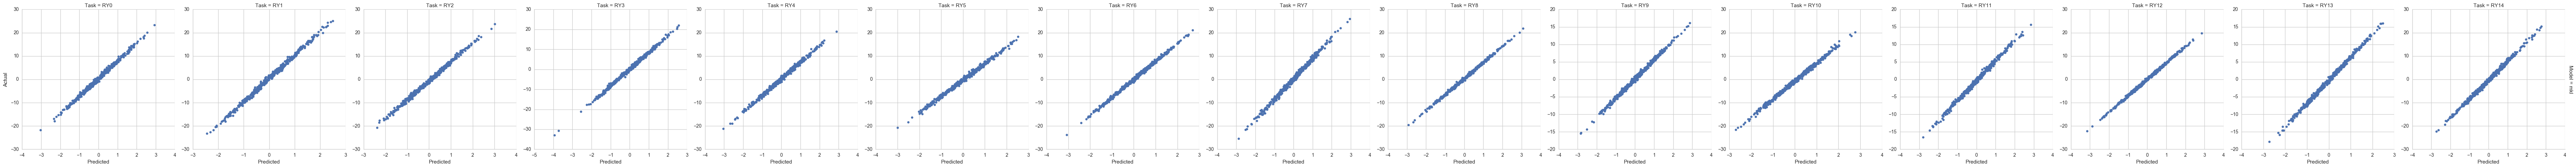

In [97]:
# Predictions on RPPA training data
Yp = pd.DataFrame(est.clf.get_tensor('qYR'), index=Yr.index, columns=Yr.columns)
d_pred_train = mkl.stack_predictions(Yp, Yr).reset_index().assign(Model='mkl', Fold=0).rename(columns={'Pred': 'Predicted'})
predictions.visualize(train_res, d_pred_train, share_axes=False)

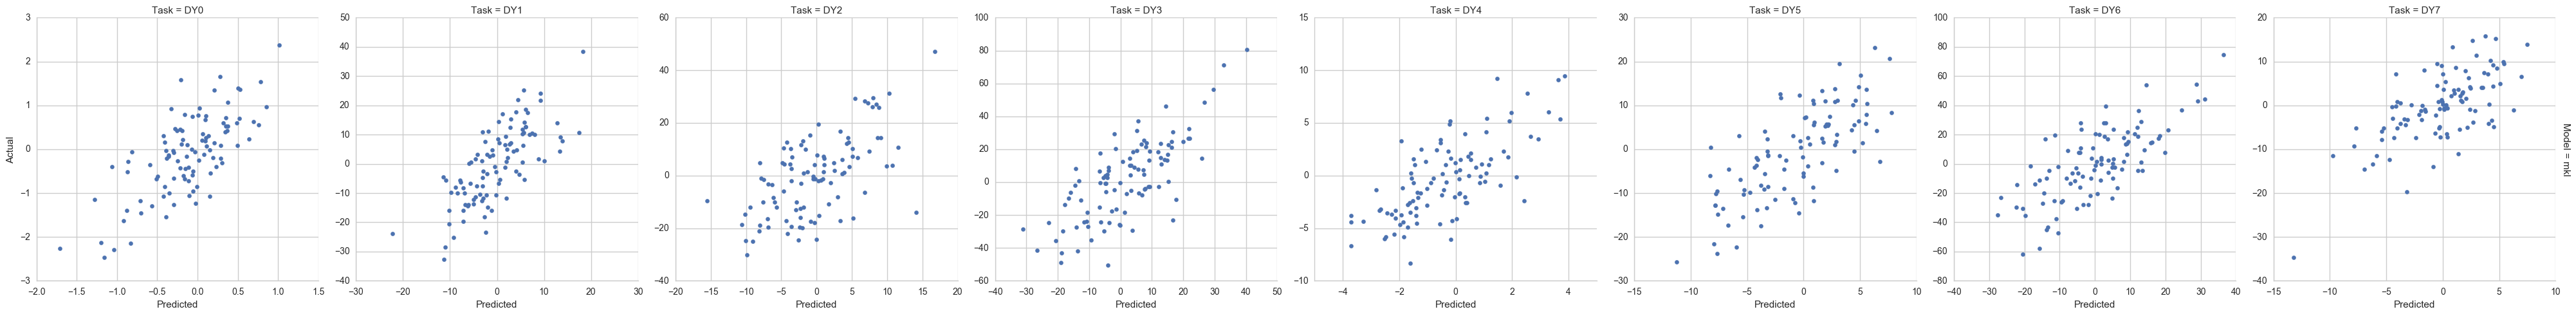

In [98]:
# Predictions on drug training data
Yp = est.clf.predict(Xd.values)
d_pred_train = mkl.stack_predictions(Yp, Yd).reset_index().assign(Model='mkl', Fold=0).rename(columns={'Pred': 'Predicted'})
predictions.visualize(train_res, d_pred_train, share_axes=False)

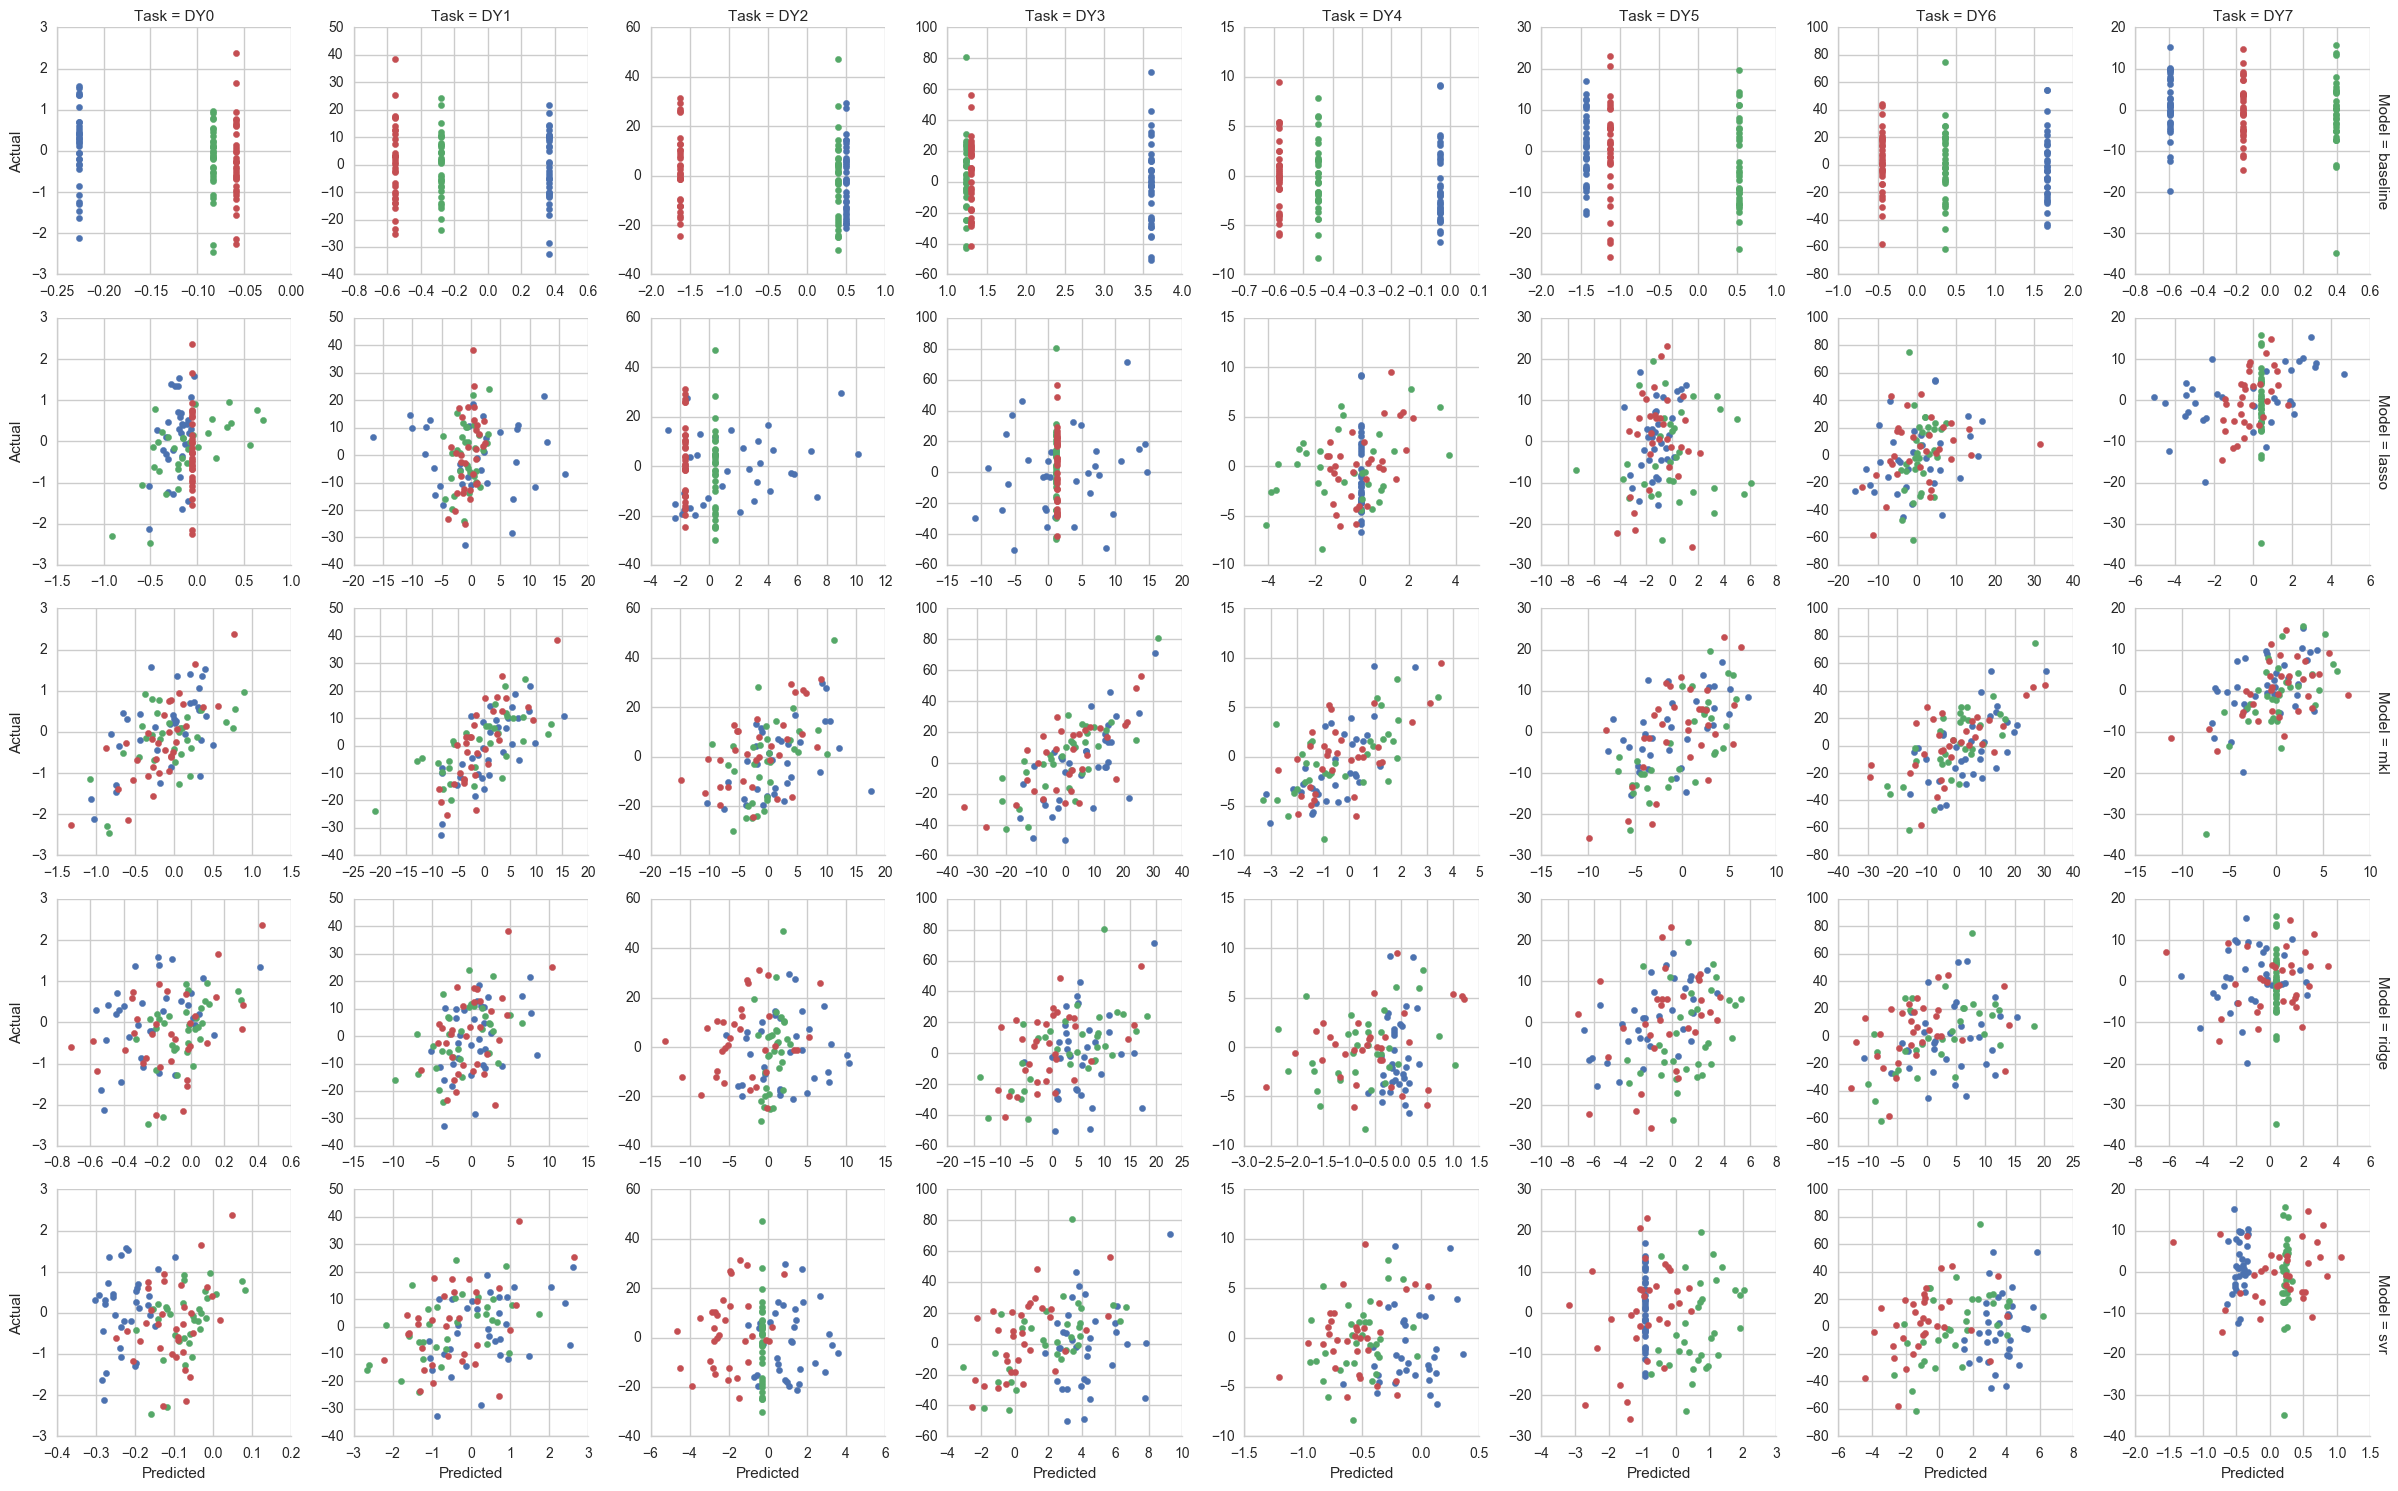

In [99]:
predictions.visualize(train_res, d_pred_melt, share_axes=False, figsize=3)

In [106]:
from ml.api.results import performance
from sklearn.metrics import mean_squared_error, r2_score

def score_fn(y_true, y_pred):
    return {
        'pearson': y_true.corr(y_pred, method='pearson'),
        'spearman': y_true.corr(y_pred, method='spearman'),
        'r2_score': r2_score(y_true, y_pred)
    }
d_score = performance.extract(train_res, d_pred, score_fn)
d_score = performance.melt(d_score)
d_score.head()

Model  Fold Task    Metric         Value
0  baseline     1  DY0   pearson -1.945067e-17
1  baseline     1  DY0  r2_score -1.083934e-01
2  baseline     1  DY1  r2_score -1.462881e-02
3  baseline     1  DY2   pearson  2.290182e-17
4  baseline     1  DY2  r2_score -2.541642e-02

In [108]:
def plot_scores(d):
    traces = []
    for k, g in d.groupby('Metric'):
        trace = go.Box(x=g['Model'], y=g['Value'], boxmean='sd', boxpoints='all', name=k)
        traces.append(trace)
#         trace = go.Scatter(x=g['Model'], y=g['Value'], text=g['Task'], mode='markers')
#         traces.append(trace)
    layout = go.Layout(boxmode='group', hovermode='closest')
    fig = go.Figure(data=traces, layout=layout)
    plty.offline.iplt(fig)
    
plot_scores(d_score)

# Effects

In [79]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['mkl']
qW = est.clf.all_tensors_['qW']

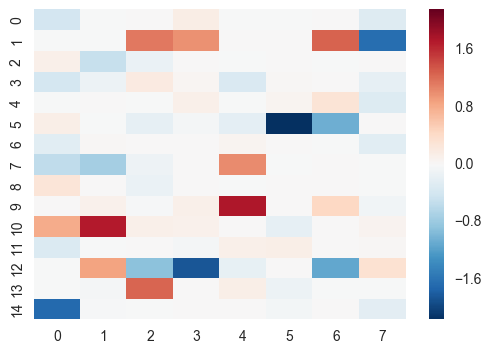

In [80]:
sns.heatmap(qW)

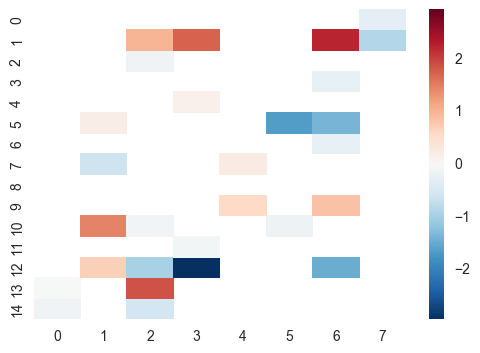

In [85]:
sns.heatmap(np.where(Wd == 0, np.nan, Wd))

In [ ]:
est.clf.all_tensors_['q']

In [17]:
# P = 100
# Nr = 200
# Nd = 20
# Tr = 10
# Td = 3

p_mkl = (Nr * Tr) + (Tr * Td)
p_lasso = P * Td
p_mkl, p_lasso

(5080, 8000)

1 6 3


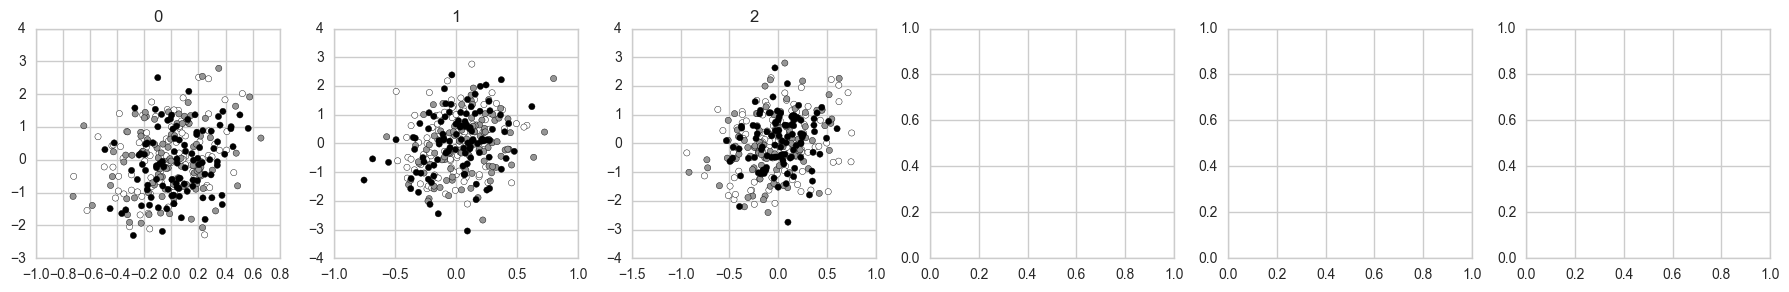

In [336]:
def plot_predictions(d_pred, model, source, ncols=6):

    d = d_pred
    d = d[d['Model'] == model]
    d = d[d['Source'] == source]
    
    tasks = d['Task'].unique()
    ntasks = len(tasks)
    nrows = int(ntasks / float(ncols)) + 1 if ntasks % ncols != 0 else int(ntasks / float(ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    print(nrows, ncols, ntasks)
    axs = axs.ravel()
    fig.set_size_inches((ncols*3, nrows*3))

    for i, t in enumerate(tasks):
        dt = d[d['Task'] == t]
        stats = dt['Actual'].describe()
        vmin, vmax = stats['min']*1.1, stats['max']*1.1
        axs[i].scatter(dt['Pred'], dt['Actual'], c=dt['Fold'])
        axs[i].set_title('{}'.format(t))
#         axs[i].set_xlim(vmin, vmax)
#         axs[i].set_ylim(vmin, vmax)
    plt.tight_layout()
        
#plot_predictions(d_pred_test.reset_index(), 'mkl', src.GDSC_v2)
#plot_predictions(d_pred_test.reset_index(), 'mkl', src.NCI60_v2)
plot_predictions(d_pred_test.reset_index(), 'svr', 'Source1')
#plot_predictions(d_pred_train.reset_index(), 'svr', 'Source2')